In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import tensorflow as tf


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=15000, random_state=0)


170498071/170498071 [==============================] - 4s 0us/step


In [3]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (35000, 32, 32, 3)
Train Labels Shape:       (35000, 1)

Validation Images Shape:  (15000, 32, 32, 3)
Validation Labels Shape:  (15000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


In [4]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

mean = np.mean(X_train)
std  = np.std(X_train)

X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [5]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

In [6]:
data_generator = ImageDataGenerator(
    rotation_range=15,

    width_shift_range=0.12,

    height_shift_range=0.12,

    horizontal_flip=True,

    zoom_range=0.1,

    brightness_range=[0.9,1.1],

    shear_range=10,

    channel_shift_range=0.1,
)

In [7]:
def create_model(normalisation_bool, dropout_bool, bias_bool, activation):
  model = Sequential()

  weight_decay = 0.0001

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay),
                  input_shape=X_train.shape[1:]))
  if normalisation_bool:
    model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay)))
  if normalisation_bool:
    model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout_bool:
    model.add(Dropout(rate=0.2))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay)))
  if normalisation_bool:
    model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay)))
  if normalisation_bool:
    model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout_bool:
    model.add(Dropout(rate=0.3))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay)))
  if normalisation_bool:
    model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay)))
  if normalisation_bool:
    model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout_bool:
    model.add(Dropout(rate=0.4))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay)))
  if normalisation_bool:
    model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation, kernel_regularizer=l2(weight_decay)))
  if normalisation_bool:
    model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout_bool:
    model.add(Dropout(rate=0.5))

  model.add(Flatten())

  if bias_bool:
    model.add(Dense(10, activation='softmax'))
  else:
    model.add(Dense(10, activation='softmax', use_bias=False))

  return model

In [8]:
def define_parameters(model, batch_size, epochs, optimizer, loss):

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

  early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

  model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_valid, y_valid),
            callbacks=[reduce_lr, early_stopping],
            verbose=2)

# Функции активации

In [9]:
activation_functions = ['linear', 'sigmoid', 'tanh', 'relu']
results = []

for activation_function in activation_functions:
    model = create_model(True, True, True, activation_function)

    define_parameters(model, 64, 5, 'adam', 'categorical_crossentropy')

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'activation_function': activation_function, 'accuracy': accuracy})

for result in results:
    print(f'{result["activation_function"]}: {result["accuracy"]}')

Epoch 1/5
547/547 - 61s - loss: 2.1405 - accuracy: 0.3347 - val_loss: 1.7920 - val_accuracy: 0.4478 - lr: 0.0010 - 61s/epoch - 111ms/step
Epoch 2/5
547/547 - 41s - loss: 1.6328 - accuracy: 0.4562 - val_loss: 1.5456 - val_accuracy: 0.5380 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 3/5
547/547 - 40s - loss: 1.4655 - accuracy: 0.5194 - val_loss: 1.4717 - val_accuracy: 0.5666 - lr: 0.0010 - 40s/epoch - 72ms/step
Epoch 4/5
547/547 - 40s - loss: 1.3841 - accuracy: 0.5519 - val_loss: 1.1714 - val_accuracy: 0.6443 - lr: 0.0010 - 40s/epoch - 73ms/step
Epoch 5/5
547/547 - 41s - loss: 1.3432 - accuracy: 0.5723 - val_loss: 1.1838 - val_accuracy: 0.6485 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 1/5
547/547 - 46s - loss: 2.2100 - accuracy: 0.3205 - val_loss: 1.6627 - val_accuracy: 0.4503 - lr: 0.0010 - 46s/epoch - 84ms/step
Epoch 2/5
547/547 - 41s - loss: 1.6320 - accuracy: 0.4504 - val_loss: 1.6812 - val_accuracy: 0.4685 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 3/5
547/547 - 41s - loss: 1.4471 -

# Bias

In [10]:
biases = [True, False]
results = []

for bias in biases:
    model = create_model(True, True, bias, 'relu')

    define_parameters(model, 64, 5, 'adam', 'categorical_crossentropy')

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'bias': bias, 'accuracy': accuracy})

for result in results:
    print(f'{result["bias"]}: {result["accuracy"]}')

Epoch 1/5
547/547 - 47s - loss: 2.3347 - accuracy: 0.3393 - val_loss: 1.6935 - val_accuracy: 0.4811 - lr: 0.0010 - 47s/epoch - 85ms/step
Epoch 2/5
547/547 - 40s - loss: 1.7688 - accuracy: 0.4578 - val_loss: 1.9803 - val_accuracy: 0.4597 - lr: 0.0010 - 40s/epoch - 73ms/step
Epoch 3/5
547/547 - 41s - loss: 1.5548 - accuracy: 0.5227 - val_loss: 1.4111 - val_accuracy: 0.5946 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 4/5
547/547 - 41s - loss: 1.3881 - accuracy: 0.5768 - val_loss: 1.5842 - val_accuracy: 0.5411 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 5/5
547/547 - 40s - loss: 1.2839 - accuracy: 0.6097 - val_loss: 1.1860 - val_accuracy: 0.6389 - lr: 0.0010 - 40s/epoch - 73ms/step
Epoch 1/5
547/547 - 45s - loss: 2.3058 - accuracy: 0.3380 - val_loss: 1.5738 - val_accuracy: 0.4791 - lr: 0.0010 - 45s/epoch - 82ms/step
Epoch 2/5
547/547 - 41s - loss: 1.7963 - accuracy: 0.4637 - val_loss: 1.5168 - val_accuracy: 0.5392 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 3/5
547/547 - 42s - loss: 1.6252 - 

# Dropout

In [11]:
dropouts = [True, False]
results = []

for dropout in dropouts:
    model = create_model(True, dropout, True, 'relu')

    define_parameters(model, 64, 5, 'adam', 'categorical_crossentropy')

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'dropout': dropout, 'accuracy': accuracy})

for result in results:
    print(f'{result["dropout"]}: {result["accuracy"]}')

Epoch 1/5
547/547 - 45s - loss: 2.3363 - accuracy: 0.3444 - val_loss: 1.5839 - val_accuracy: 0.4943 - lr: 0.0010 - 45s/epoch - 82ms/step
Epoch 2/5
547/547 - 41s - loss: 1.8521 - accuracy: 0.4461 - val_loss: 1.6203 - val_accuracy: 0.4844 - lr: 0.0010 - 41s/epoch - 74ms/step
Epoch 3/5
547/547 - 40s - loss: 1.6464 - accuracy: 0.5079 - val_loss: 1.5042 - val_accuracy: 0.5239 - lr: 0.0010 - 40s/epoch - 73ms/step
Epoch 4/5
547/547 - 42s - loss: 1.4712 - accuracy: 0.5477 - val_loss: 1.3158 - val_accuracy: 0.5969 - lr: 0.0010 - 42s/epoch - 76ms/step
Epoch 5/5
547/547 - 41s - loss: 1.3217 - accuracy: 0.5939 - val_loss: 1.2827 - val_accuracy: 0.6022 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 1/5
547/547 - 45s - loss: 1.7274 - accuracy: 0.4369 - val_loss: 1.3838 - val_accuracy: 0.5514 - lr: 0.0010 - 45s/epoch - 82ms/step
Epoch 2/5
547/547 - 40s - loss: 1.3150 - accuracy: 0.5736 - val_loss: 1.1595 - val_accuracy: 0.6343 - lr: 0.0010 - 40s/epoch - 73ms/step
Epoch 3/5
547/547 - 39s - loss: 1.1238 - 

# BatchNormalization

In [12]:
normalisations = [True, False]
results = []

for normalisation in normalisations:
    model = create_model(normalisation, True, True, 'relu')

    define_parameters(model, 64, 5, 'adam', 'categorical_crossentropy')

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'normalisation': normalisation, 'accuracy': accuracy})

for result in results:
    print(f'{result["normalisation"]}: {result["accuracy"]}')

Epoch 1/5
547/547 - 46s - loss: 2.3361 - accuracy: 0.3381 - val_loss: 1.7303 - val_accuracy: 0.4540 - lr: 0.0010 - 46s/epoch - 84ms/step
Epoch 2/5
547/547 - 40s - loss: 1.8648 - accuracy: 0.4486 - val_loss: 1.4366 - val_accuracy: 0.5223 - lr: 0.0010 - 40s/epoch - 74ms/step
Epoch 3/5
547/547 - 40s - loss: 1.6680 - accuracy: 0.5040 - val_loss: 1.3596 - val_accuracy: 0.5590 - lr: 0.0010 - 40s/epoch - 74ms/step
Epoch 4/5
547/547 - 46s - loss: 1.4992 - accuracy: 0.5489 - val_loss: 1.3213 - val_accuracy: 0.6145 - lr: 0.0010 - 46s/epoch - 84ms/step
Epoch 5/5
547/547 - 41s - loss: 1.3607 - accuracy: 0.5936 - val_loss: 1.1512 - val_accuracy: 0.6513 - lr: 0.0010 - 41s/epoch - 74ms/step
Epoch 1/5
547/547 - 42s - loss: 1.8565 - accuracy: 0.3075 - val_loss: 1.6641 - val_accuracy: 0.4037 - lr: 0.0010 - 42s/epoch - 76ms/step
Epoch 2/5
547/547 - 39s - loss: 1.5416 - accuracy: 0.4463 - val_loss: 1.3918 - val_accuracy: 0.5143 - lr: 0.0010 - 39s/epoch - 71ms/step
Epoch 3/5
547/547 - 38s - loss: 1.3919 - 

# Batch size

In [13]:
batches = [32, 64, 128]
results = []

for batch in batches:
    model = create_model(True, True, True, 'relu')

    define_parameters(model, batch, 5, 'adam', 'categorical_crossentropy')

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'batch': batch, 'accuracy': accuracy})

for result in results:
    print(f'{result["batch"]}: {result["accuracy"]}')

Epoch 1/5
1094/1094 - 51s - loss: 2.3299 - accuracy: 0.3445 - val_loss: 1.6115 - val_accuracy: 0.4777 - lr: 0.0010 - 51s/epoch - 47ms/step
Epoch 2/5
1094/1094 - 43s - loss: 1.7780 - accuracy: 0.4575 - val_loss: 1.4465 - val_accuracy: 0.5463 - lr: 0.0010 - 43s/epoch - 40ms/step
Epoch 3/5
1094/1094 - 45s - loss: 1.5316 - accuracy: 0.5308 - val_loss: 1.2465 - val_accuracy: 0.6193 - lr: 0.0010 - 45s/epoch - 41ms/step
Epoch 4/5
1094/1094 - 44s - loss: 1.3760 - accuracy: 0.5851 - val_loss: 1.2085 - val_accuracy: 0.6496 - lr: 0.0010 - 44s/epoch - 40ms/step
Epoch 5/5
1094/1094 - 45s - loss: 1.2932 - accuracy: 0.6215 - val_loss: 1.1317 - val_accuracy: 0.6831 - lr: 0.0010 - 45s/epoch - 41ms/step
Epoch 1/5
547/547 - 45s - loss: 2.3119 - accuracy: 0.3310 - val_loss: 2.0482 - val_accuracy: 0.4270 - lr: 0.0010 - 45s/epoch - 83ms/step
Epoch 2/5
547/547 - 41s - loss: 1.7790 - accuracy: 0.4556 - val_loss: 1.4505 - val_accuracy: 0.5263 - lr: 0.0010 - 41s/epoch - 74ms/step
Epoch 3/5
547/547 - 40s - loss:

# Optimizers

In [14]:
optimizers = {
    'adam': tf.keras.optimizers.Adam(learning_rate=0.001),
    'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=0.001),
    'nesterov': tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
}
results = []

for optimizer_name, optimizer in optimizers.items():
    model = create_model(True, True, True, 'relu')

    define_parameters(model, 64, 5, optimizer, 'categorical_crossentropy')

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'optimizer': optimizer_name, 'accuracy': accuracy})

for result in results:
    print(f'{result["optimizer"]}: {result["accuracy"]}')

Epoch 1/5
547/547 - 47s - loss: 2.3340 - accuracy: 0.3491 - val_loss: 1.6180 - val_accuracy: 0.4850 - lr: 0.0010 - 47s/epoch - 85ms/step
Epoch 2/5
547/547 - 41s - loss: 1.7114 - accuracy: 0.4727 - val_loss: 1.6198 - val_accuracy: 0.5043 - lr: 0.0010 - 41s/epoch - 74ms/step
Epoch 3/5
547/547 - 40s - loss: 1.5129 - accuracy: 0.5307 - val_loss: 1.3459 - val_accuracy: 0.5765 - lr: 0.0010 - 40s/epoch - 74ms/step
Epoch 4/5
547/547 - 41s - loss: 1.3589 - accuracy: 0.5767 - val_loss: 1.3564 - val_accuracy: 0.5978 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 5/5
547/547 - 41s - loss: 1.2710 - accuracy: 0.6147 - val_loss: 1.2221 - val_accuracy: 0.6327 - lr: 0.0010 - 41s/epoch - 75ms/step
Epoch 1/5
547/547 - 45s - loss: 2.3358 - accuracy: 0.3509 - val_loss: 1.8139 - val_accuracy: 0.4174 - lr: 0.0010 - 45s/epoch - 82ms/step
Epoch 2/5
547/547 - 39s - loss: 1.7907 - accuracy: 0.4823 - val_loss: 1.4529 - val_accuracy: 0.5724 - lr: 0.0010 - 39s/epoch - 72ms/step
Epoch 3/5
547/547 - 40s - loss: 1.5390 - 

# Loss functions

In [15]:
loss_functions = {
    'binary_crossentropy',
    'categorical_crossentropy',
    'mean_squared_error'
}

results = []

for loss_function in loss_functions:
    model = create_model(True, True, True, 'relu')

    define_parameters(model, 64, 5, 'adam', loss_function)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'loss_function': loss_function, 'accuracy': accuracy})

for result in results:
    print(f'{result["loss_function"]}: {result["accuracy"]}')

Epoch 1/5
547/547 - 46s - loss: 0.1583 - accuracy: 0.3159 - val_loss: 0.1233 - val_accuracy: 0.4574 - lr: 0.0010 - 46s/epoch - 85ms/step
Epoch 2/5
547/547 - 40s - loss: 0.1118 - accuracy: 0.4598 - val_loss: 0.0962 - val_accuracy: 0.5338 - lr: 0.0010 - 40s/epoch - 73ms/step
Epoch 3/5
547/547 - 39s - loss: 0.0933 - accuracy: 0.5077 - val_loss: 0.0910 - val_accuracy: 0.5391 - lr: 0.0010 - 39s/epoch - 72ms/step
Epoch 4/5
547/547 - 39s - loss: 0.0908 - accuracy: 0.5193 - val_loss: 0.0881 - val_accuracy: 0.5447 - lr: 0.0010 - 39s/epoch - 72ms/step
Epoch 5/5
547/547 - 40s - loss: 0.0932 - accuracy: 0.5161 - val_loss: 0.0969 - val_accuracy: 0.5612 - lr: 0.0010 - 40s/epoch - 74ms/step
Epoch 1/5
547/547 - 47s - loss: 0.4032 - accuracy: 0.3516 - val_loss: 0.3208 - val_accuracy: 0.4905 - lr: 0.0010 - 47s/epoch - 85ms/step
Epoch 2/5
547/547 - 41s - loss: 0.3227 - accuracy: 0.4809 - val_loss: 0.2981 - val_accuracy: 0.5458 - lr: 0.0010 - 41s/epoch - 74ms/step
Epoch 3/5
547/547 - 39s - loss: 0.2802 - 

# Final version

In [16]:
model = create_model(True, False, True, 'relu')

define_parameters(model, 64, 100, tf.keras.optimizers.RMSprop(learning_rate=0.001), 'binary_crossentropy')

Epoch 1/100
547/547 - 44s - loss: 0.3281 - accuracy: 0.4508 - val_loss: 0.2487 - val_accuracy: 0.6084 - lr: 0.0010 - 44s/epoch - 81ms/step
Epoch 2/100
547/547 - 40s - loss: 0.2442 - accuracy: 0.6123 - val_loss: 0.2102 - val_accuracy: 0.6759 - lr: 0.0010 - 40s/epoch - 72ms/step
Epoch 3/100
547/547 - 39s - loss: 0.2116 - accuracy: 0.6723 - val_loss: 0.1918 - val_accuracy: 0.7126 - lr: 0.0010 - 39s/epoch - 72ms/step
Epoch 4/100
547/547 - 38s - loss: 0.1902 - accuracy: 0.7117 - val_loss: 0.1881 - val_accuracy: 0.7193 - lr: 0.0010 - 38s/epoch - 70ms/step
Epoch 5/100
547/547 - 38s - loss: 0.1786 - accuracy: 0.7365 - val_loss: 0.1726 - val_accuracy: 0.7553 - lr: 0.0010 - 38s/epoch - 69ms/step
Epoch 6/100
547/547 - 38s - loss: 0.1700 - accuracy: 0.7553 - val_loss: 0.1856 - val_accuracy: 0.7385 - lr: 0.0010 - 38s/epoch - 70ms/step
Epoch 7/100
547/547 - 40s - loss: 0.1660 - accuracy: 0.7660 - val_loss: 0.1566 - val_accuracy: 0.7858 - lr: 0.0010 - 40s/epoch - 74ms/step
Epoch 8/100
547/547 - 37s -

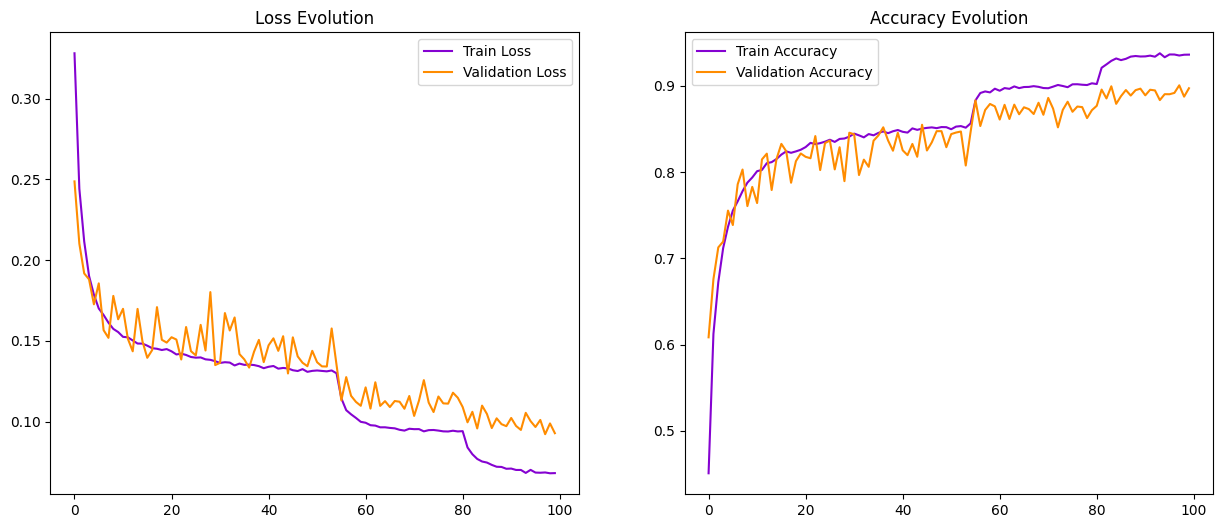

In [17]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 1s 4ms/step - loss: 0.0947 - accuracy: 0.8945

Test Accuracy: 0.8945000171661377
Test Loss:     0.09469038993120193
